In [79]:
import numpy as np
import pandas as pd
import sqlite3
from tqdm import tqdm
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
%config InlineBackend.figure_format = 'retina'

In [2]:
conn = sqlite3.connect('./dataset/finalTrain.db')
train = pd.read_sql_query('SELECT * FROM train', conn)
valid = pd.read_sql_query('SELECT * FROM validation', conn)

In [3]:
tqdm.pandas()

In [4]:
data = pd.concat([train, valid], ignore_index=True)

In [5]:
data['body'] = data.body.progress_apply(lambda x: re.sub('/', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('@', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('\[', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('\]', '', x))

100%|██████████| 4206307/4206307 [00:10<00:00, 392465.28it/s]


In [6]:
data.shape

(4206307, 11)

In [7]:
data.dropna(subset=['body'], inplace=True)

In [8]:
data.shape

(4206307, 11)

In [8]:
data.head()

,Id,Title,Tags,title_length,best_tags,body_length,code,body,possbleCpp,possbleJava,possbleC#
0,1,check upload file imag without mime type,php image-processing file-upload upload mime-t...,63,php,408,,i like to check if an upload file is an imag ...,0,0,0
1,2,prevent firefox close press ctrl-w,firefox,58,other,360,,in my favorit editor vim i regular use ctrl...,0,0,0
2,3,r error invalid type list variabl,r matlab machine-learning,40,other,13532,Error in model.frame.default(formula = expert_...,i am import matlab file and construct a data f...,0,0,0
3,4,replac special charact url,c# url encoding,45,c#,562,,this is probabl veri simpl but i simpli can n...,0,0,0
4,5,modifi whoi contact detail,php api file-get-contents,36,php,990,function modify(.......)\n{\n $mcontact = fil...,use this modifi function display warn mesag p...,0,0,0


### Sample the dataset

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [10]:
sample = data.sample(500000)

In [11]:
sample.shape

(500000, 11)

### Choosing top tags

In [12]:
sample.dropna(inplace=True)

In [13]:
sample.shape

(500000, 11)

In [14]:
vectorizer = CountVectorizer(tokenizer= lambda x: x.split(), binary=True)
multilabel_y = vectorizer.fit_transform(sample.Tags)

In [15]:
multilabel_y.shape

(500000, 30669)

### Check the infection point for number of tags

In [16]:
nTags = multilabel_y.shape[1]

In [17]:
question_explained = {}

In [18]:
for i in tqdm(range(500, nTags, 100)):
    t = np.array(multilabel_y.sum(axis=0))[0]
    multilabel_yn = multilabel_y[:, np.argsort(t)[::-1][0:i]]
    nz = np.count_nonzero(multilabel_yn.sum(axis=1))
    question_explained[i] = nz

100%|██████████| 302/302 [00:23<00:00, 11.70it/s]


In [19]:
qe = pd.DataFrame.from_dict(question_explained, orient='index')
qe.columns = ['questionExplained']
qe['questionExplained'] = qe.questionExplained / sample.shape[0] * 100.0

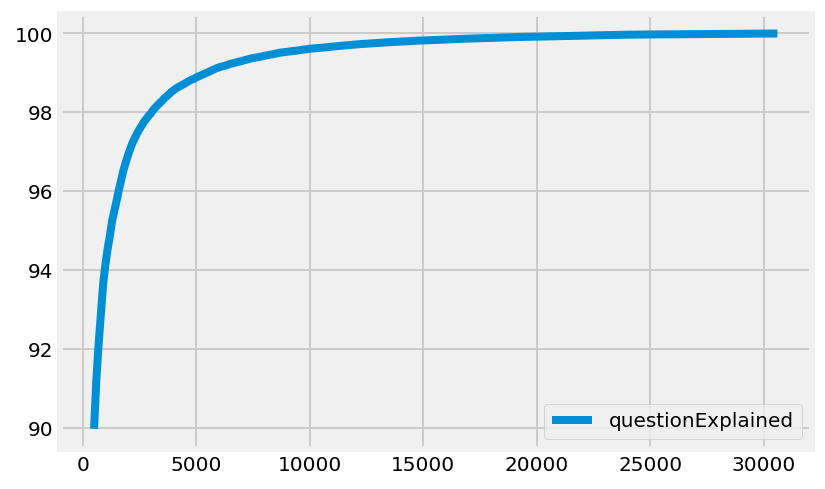

In [20]:
qe.plot.line();

In [23]:
qe.loc[500]

questionExplained    89.974
Name: 500, dtype: float64

In [24]:
question_explained[500] / sample.shape[0]

0.89974

#### Splitting the data

In [2]:
from scipy.sparse import load_npz, save_npz

In [27]:
t = np.array(multilabel_y.sum(axis=0))[0]
sampleY = multilabel_y[:, np.argsort(t)[::-1][0:500]]

In [29]:
# Xtrain = sample.head(2000000)
ytrain = sampleY[0:400000, :]
# Xtest = sample.tail(1000000)
ytest = sampleY[400000:500000, :]

In [28]:
save_npz('sampleY.npz', sampleY)

In [30]:
ytrain.shape

(400000, 500)

In [31]:
ytest.shape

(100000, 500)

### Featurize the data

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))

In [34]:
# sample.drop(['Id', 'title_length', 
#             'best_tags', 'body_length', 'code',
#             'possbleCpp', 'possbleJava', 'possbleC#'], axis=1, inplace=True)

#### Multiplying the title 3 times

In [35]:
sample['Title'] = sample.Title.progress_apply(lambda x: " ".join([x] * 3))

100%|██████████| 500000/500000 [00:01<00:00, 478918.49it/s]


In [8]:
from datetime import datetime

In [37]:
start = datetime.now()
sampleX = vectorizer.fit_transform(sample.Title)
print("Time taken :", datetime.now() - start)

Time taken : 0:01:05.382489


In [2]:
conn = sqlite3.connect('dataset/sample.db')
sample = pd.read_sql_query('SELECT * FROM sample', conn)

In [5]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))

In [8]:
start = datetime.now()
sampleX_body = vectorizer.fit_transform(sample.body)
print("Time taken :", datetime.now() - start)

Time taken : 0:11:02.263474


In [9]:
sampleX_body.shape

(500000, 100000)

In [5]:
sampleY = load_npz('sampleY.npz')
# sampleX = load_npz('sampleX.npz')
sampleX_body = load_npz('sampleX_body.npz')

### Fitting the OvR models

##### Fitting on the titles

In [3]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

In [9]:
x_train_multilabel = sampleX_body[0:400000, :]
y_train = sampleY[0:400000, :]
x_test_multilabel = sampleX_body[400000:500000, :]
y_test = sampleY[400000:500000, :]

In [10]:
x_train_multilabel.shape

(400000, 100000)

In [11]:
y_train.shape

(400000, 500)

#### Training on the title X 3 times

In [11]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1', verbose=2), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
print("Time taken :", datetime.now() - start)

Time taken : 0:00:54.484018


In [12]:
predictions = classifier.predict(x_test_multilabel)

In [5]:
from sklearn import metrics

In [15]:
start = datetime.now()
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = metrics.precision_score(y_test, predictions, average='macro')
recall = metrics.recall_score(y_test, predictions, average='macro')
f1 = metrics.f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

# print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.22911
Hamming loss  0.002852
Micro-average quality numbers
Precision: 0.7542, Recall: 0.3122, F1-measure: 0.4416
Macro-average quality numbers
Precision: 0.5575, Recall: 0.2405, F1-measure: 0.3211
Time taken to run this cell : 0:00:00.079012


#### Training on the body

In [14]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1', verbose=2), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
print("Time taken :", datetime.now() - start)

Time taken : 0:09:28.714296


In [18]:
predictions = classifier.predict(x_test_multilabel)

In [19]:
start = datetime.now()
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = metrics.precision_score(y_test, predictions, average='macro')
recall = metrics.recall_score(y_test, predictions, average='macro')
f1 = metrics.f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

# print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.17606
Hamming loss  0.00317382
Micro-average quality numbers
Precision: 0.6796, Recall: 0.2297, F1-measure: 0.3433
Macro-average quality numbers
Precision: 0.4626, Recall: 0.1414, F1-measure: 0.2060
Time taken to run this cell : 0:00:00.158702


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


It seems that 3x title is more valiable in terms of F1 score. Let's now combine the 3x title and body and see if the number improves or not.

In [2]:
with sqlite3.connect('dataset/sample.db') as conn:
    sample = pd.read_sql_query('SELECT * FROM sample', conn)

In [3]:
sample.shape

(500000, 12)

In [4]:
sample.head()

,index,Id,Title,Tags,title_length,best_tags,body_length,code,body,possbleCpp,possbleJava,possbleC#
0,1937810,2205304,add extra space bottom gridview listview add e...,android android-gridview,51,android,309,paddingBottom\n,is it possibl to add extra space kinda like a...,0,0,0
1,2485602,2959225,iphon check valu cellid lac iphon check valu c...,iphone cellid,36,other,142,,i can get radio inform cellid lac mnc mcc o...,0,0,0
2,963519,1022370,use compress improv edit distanc comput use co...,reference-request ho.history-overview string-m...,54,other,504,,i am do a seminar on a paper titl a rel nof...,0,0,0
3,1867571,2113629,yahoo gmail send mail oauth use java yahoo gma...,java oauth smtp javamail,42,java,972,Properties props = new Properties();\nprops.pu...,by use xoauth i am get imapstor and smtptransp...,0,0,0
4,1300853,1412391,load page use jqueri load page use jqueri load...,jquery jquery-ajax,24,js,647,var html = $.ajax({\n url: ...,i want to know about the error happen dure ins...,0,0,0


In [6]:
sample.Title[0] # 3x title

'add extra space bottom gridview listview add extra space bottom gridview listview add extra space bottom gridview listview'

In [7]:
sample.body[0] # body

'is it possibl to add extra space  kinda like an empti row  to the bottom of a gridview  i would like it so when you scroll down to the bottom of a gridview  there will be an extra dp of empti space  i tri set  code  paddingbottom    to dp  but it did nt seem to chang anyth '

In [8]:
sample['question'] = sample.Title + ' ' + sample.body

In [10]:
sample.question[0]

'add extra space bottom gridview listview add extra space bottom gridview listview add extra space bottom gridview listview is it possibl to add extra space  kinda like an empti row  to the bottom of a gridview  i would like it so when you scroll down to the bottom of a gridview  there will be an extra dp of empti space  i tri set  code  paddingbottom    to dp  but it did nt seem to chang anyth '

In [12]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))

In [15]:
start = datetime.now()
sampleX_questions = vectorizer.fit_transform(sample.question)
print("Time taken :", datetime.now() - start)

Time taken : 0:21:30.963244


In [17]:
save_npz('sampleX_questions.npz', sampleX_questions)

#### Training on both body + title x 3

In [4]:
sampleY = load_npz('sampleY.npz')
sampleX_questions = load_npz('sampleX_questions.npz')

In [5]:
x_train_multilabel = sampleX_questions[0:400000, :]
y_train = sampleY[0:400000, :]
x_test_multilabel = sampleX_questions[400000:500000, :]
y_test = sampleY[400000:500000, :]

In [10]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1', verbose=2), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
print("Time taken :", datetime.now() - start)

Time taken : 0:12:41.595459


In [11]:
predictions = classifier.predict(x_test_multilabel)

In [12]:
start = datetime.now()
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = metrics.precision_score(y_test, predictions, average='macro')
recall = metrics.recall_score(y_test, predictions, average='macro')
f1 = metrics.f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


# print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.237
Hamming loss  0.0027848
Micro-average quality numbers
Precision: 0.7479, Recall: 0.3456, F1-measure: 0.4728
Macro-average quality numbers
Precision: 0.5581, Recall: 0.2528, F1-measure: 0.3318
Time taken to run this cell : 0:00:00.161546


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Hyperparam tuning with Log loss (Logistic Regression)

In [102]:
f1_micro_scores = []
f1_macro_scores = []
accuracy_scores = []
precision_micro_scores = []
recall_micro_scores = []
precison_macro_scores = []
recall_macro_scores = []
hamming_loss = []

In [45]:
from sklearn import metrics

In [ ]:
for alpha in [10, 1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]:
    print(f'Started fro the alpha {alpha}')
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', verbose=2, alpha=alpha), n_jobs=-1)
    classifier.fit(x_train_multilabel, y_train)
    print(f'Started prediting for {alpha}')
    predictions = classifier.predict(x_test_multilabel)
    accuracy_scores.append(metrics.accuracy_score(y_test, predictions))
    hamming_loss.append(metrics.hamming_loss(y_test,predictions))
    precision_micro_scores.append(metrics.precision_score(y_test, predictions, average='micro'))
    recall_micro_scores.append(metrics.recall_score(y_test, predictions, average='micro'))
    f1_micro_scores.append(metrics.f1_score(y_test, predictions, average='micro'))
    f1_macro_scores.append(metrics.precision_score(y_test, predictions, average='macro'))
    recall_macro_scores.append(metrics.recall_score(y_test, predictions, average='macro'))
    f1_macro_scores.append(metrics.f1_score(y_test, predictions, average='macro'))
    print(f'Done for the {alpha}')

In [71]:
scores = pd.DataFrame([
    [10, 1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001],
    f1_micro_scores,
    hamming_loss,
    recall_micro_scores,
    precision_micro_scores
]).T
scores.columns = ['alphas', 'f1_micro', 'hamming', 'recall_micro', 'precision_micro']

In [84]:
scores.sort_values('alphas', ascending=True, inplace=True)

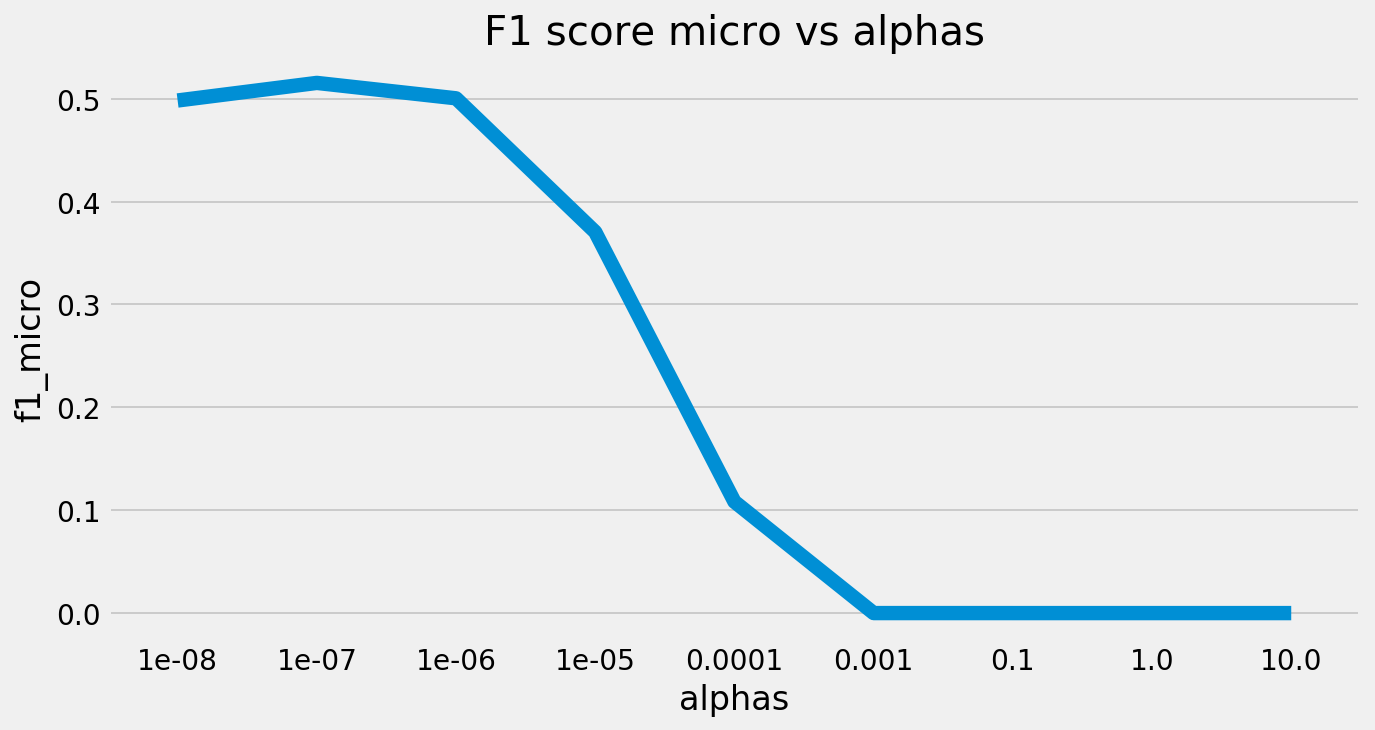

In [95]:
sns.pointplot(x='alphas', y='f1_micro', data=scores, lw=1, markers='');
plt.title('F1 score micro vs alphas');

In [103]:
for alpha in [0.000005, 0.0000001, 0.0000005]:
    print(f'Started fro the alpha {alpha}')
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', verbose=2, alpha=alpha), n_jobs=-1)
    classifier.fit(x_train_multilabel, y_train)
    print(f'Started prediting for {alpha}')
    predictions = classifier.predict(x_test_multilabel)
    accuracy_scores.append(metrics.accuracy_score(y_test, predictions))
    hamming_loss.append(metrics.hamming_loss(y_test,predictions))
    precision_micro_scores.append(metrics.precision_score(y_test, predictions, average='micro'))
    recall_micro_scores.append(metrics.recall_score(y_test, predictions, average='micro'))
    f1_micro_scores.append(metrics.f1_score(y_test, predictions, average='micro'))
    f1_macro_scores.append(metrics.precision_score(y_test, predictions, average='macro'))
    recall_macro_scores.append(metrics.recall_score(y_test, predictions, average='macro'))
    f1_macro_scores.append(metrics.f1_score(y_test, predictions, average='macro'))
    print(f'Done for the {alpha}')

Started fro the alpha 1e-07
Started prediting for 1e-07
Done for the 1e-07


In [117]:
f1_micro_scores = []
f1_macro_scores = []
accuracy_scores = []
precision_micro_scores = []
recall_micro_scores = []
precison_macro_scores = []
recall_macro_scores = []
hamming_loss = []

In [ ]:
for p in ['l1', 'l2']:
    print(f'Started for the penalty {p}')
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', verbose=2, 
                                                   alpha=0.0000005, penalty=p), n_jobs=-1)
    classifier.fit(x_train_multilabel, y_train)
    print(f'Started prediting for {p}')
    predictions = classifier.predict(x_test_multilabel)
    accuracy_scores.append(metrics.accuracy_score(y_test, predictions))
    hamming_loss.append(metrics.hamming_loss(y_test,predictions))
    precision_micro_scores.append(metrics.precision_score(y_test, predictions, average='micro'))
    recall_micro_scores.append(metrics.recall_score(y_test, predictions, average='micro'))
    f1_micro_scores.append(metrics.f1_score(y_test, predictions, average='micro'))
    f1_macro_scores.append(metrics.precision_score(y_test, predictions, average='macro'))
    recall_macro_scores.append(metrics.recall_score(y_test, predictions, average='macro'))
    f1_macro_scores.append(metrics.f1_score(y_test, predictions, average='macro'))
    print(f'Done for the {p}')

In [119]:
f1_micro_scores

[0.5299875080648482, 0.5130565261040564]

In [127]:
f1_micro_scores = []
f1_macro_scores = []
accuracy_scores = []
precision_micro_scoresdd = []
recall_micro_scores = []
precison_macro_scores = []
recall_macro_scores = []
hamming_loss = []

In [ ]:
for lr in ['optimal', 'adaptive']:
    print(f'Started for the learning rate {lr}')
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', verbose=2, 
                                                   alpha=0.0000005, penalty='l1',
                                                  learning_rate=lr, eta0=0.1), n_jobs=-1)
    classifier.fit(x_train_multilabel, y_train)
    print(f'Started prediting for {lr}')
    predictions = classifier.predict(x_test_multilabel)
    accuracy_scores.append(metrics.accuracy_score(y_test, predictions))
    hamming_loss.append(metrics.hamming_loss(y_test,predictions))
    precision_micro_scores.append(metrics.precision_score(y_test, predictions, average='micro'))
    recall_micro_scores.append(metrics.recall_score(y_test, predictions, average='micro'))
    f1_micro_scores.append(metrics.f1_score(y_test, predictions, average='micro'))
    f1_macro_scores.append(metrics.precision_score(y_test, predictions, average='macro'))
    recall_macro_scores.append(metrics.recall_score(y_test, predictions, average='macro'))
    f1_macro_scores.append(metrics.f1_score(y_test, predictions, average='macro'))
    print(f'Done for the {lr}')

In [129]:
f1_micro_scores

[0.5316527549335075, 0.47777045941050555]

In [134]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', verbose=2, 
                                                   alpha=0.0000005, penalty='l1',
                                                  learning_rate='optimal', eta0=0.1), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
print("Time taken :", datetime.now() - start)

Time taken : 0:12:42.817197


In [135]:
predictions = classifier.predict(x_test_multilabel)

In [136]:
start = datetime.now()
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = metrics.precision_score(y_test, predictions, average='macro')
recall = metrics.recall_score(y_test, predictions, average='macro')
f1 = metrics.f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


# print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25445
Hamming loss  0.00273776
Micro-average quality numbers
Precision: 0.6966, Recall: 0.4289, F1-measure: 0.5309
Macro-average quality numbers
Precision: 0.5709, Recall: 0.3370, F1-measure: 0.4121
Time taken to run this cell : 0:00:00.179849


#### Training with Hinge loss (LinearSVC) with optimized parameters

In [137]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', verbose=2, 
                                                   alpha=0.0000005, penalty='l1',
                                                  learning_rate='optimal', eta0=0.1), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
print("Time taken :", datetime.now() - start)

Time taken : 0:10:20.819282


In [138]:
predictions = classifier.predict(x_test_multilabel)

In [139]:
start = datetime.now()
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = metrics.precision_score(y_test, predictions, average='micro')
recall = metrics.recall_score(y_test, predictions, average='micro')
f1 = metrics.f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = metrics.precision_score(y_test, predictions, average='macro')
recall = metrics.recall_score(y_test, predictions, average='macro')
f1 = metrics.f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


# print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.24594
Hamming loss  0.00283904
Micro-average quality numbers
Precision: 0.6585, Recall: 0.4448, F1-measure: 0.5309
Macro-average quality numbers
Precision: 0.5586, Recall: 0.3486, F1-measure: 0.4127
Time taken to run this cell : 0:00:00.181645


/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
